In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import * 

# IV skew 的统计分析

## 1. IV Skew 的本质  

- **隐含波动率曲线（IV Curve）**：同一到期日、不同执行价的期权，其隐含波动率通常会随着执行价高低而有系统性变化──这就是 IV 曲线。  
- **整体 Skew（Slope）**：把执行价的对数偏离度 $\log(K/S)$（log-moneyness）当自变量，IV 做线性回归，回归斜率即整体 Skew。  
- **局部 Skew（Local Skew 或 Skew per Step）**：用相邻档位的 IV 差分近似导出数值，更聚焦于每个 strike 附近的斜度。

---

## 2. 用 ATM 基准和步长计算 `skew_per_step`  

1. **确定 ATM**  
   - 每分钟（及每个到期日）选出最接近底层价格 $S$ 的执行价 $K_{\rm atm}$，并取其 IV 为 $\text{IV}_{\rm atm}$。  
2. **量化步长**  
   - CF 合约的最小行权价步长是 200 点。  
   - 定义  
     $$
       \Delta_\text{steps} = \frac{K - K_{\rm atm}}{200}
     $$
3. **局部偏度**  
   - 对每一行  
     $$
       \text{skew\_per\_step} \;=\;
       \frac{\text{IV}(K) - \text{IV}_{\rm atm}}{\Delta_\text{steps}}
       \quad(\Delta_\text{steps}\neq0)
     $$
   - ATM 档位 $\Delta_\text{steps}=0$ 时，可将 `skew_per_step` 设为 NaN。

---

## 3. 滚动分位数：捕捉 “异常” Skew  

我们要知道在历史同档位下，这个 `skew_per_step` 正常分布在哪里，然后当前值落在某个极端分位就发信号。

1. **按档位分组**  
   $$
     \text{for each }\;d\in\{\dots,-2,-1,1,2,\dots\}:\;
     X_{d,t} = \bigl\{\text{skew\_per\_step}(t') \mid \Delta_\text{steps}=d,\;t'\le t\}
   $$
2. **滑动窗口**  
   - 用过去 $W$ 条记录（或过往 $D$ 交易日同一分钟点的样本）做窗口。  
   - 窗口大小建议：$W\approx3\text{天}\times240\text{分钟}=720$条，或按分钟数直接定 $W$。  
3. **计算 quantile**  
   - 对每组 $X_{d,t}$ 维护  
     $
       q_{d,t}^{\alpha} = \operatorname{Quantile}\bigl(X_{d,t},\,\alpha\bigr)
     $
   - 常用 $\alpha=0.90,0.95$（做 Put Spread）、$\alpha=0.10,0.05$（做 Call Spread）。
4. **信号触发**  
   - **做多 Put Spread**（捕捉恐慌过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}>q^{0.90}_{d,t}
     $$
   - **做多 Call Spread**（捕捉乐观过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}<q^{0.10}_{d,t}
     $$

---

## 4. 实践要点与优化  

- **最低档位筛选**：一般跳过 $|\Delta_\text{steps}|<2$的档位，过滤流动性差、噪声大的近 ATM 档。  
- **最少样本期**：window 内至少保留 $\min\_periods$个样本（例如 1000 条）再开始计算 quantile，避免极端失真。  
- **平滑处理**：如信号过于抖动，可对 `skew_per_step` 做短窗口（3–5 分钟） rolling mean，再比较分位数。  
- **信号冷却**：一旦同档位触发信号，设置几分钟内不重复进场，防止高频震荡。  
- **止盈止损**：例如 skew 回归至历史中位数（50% 分位）时平仓，或达到固定持有分钟数后强制平仓。  
- **回测验证**：  
  1. 在历史分钟线数据上模拟开／平仓，记录 P&L 曲线、胜率、Sharpe。  
  2. 网格搜索 $\{\alpha\in[0.90,0.95],\,W\in[2000,10000],\,|\Delta_\text{steps}|\ge2\}$ 等参数组合。  

---

### 小结

- **核心指标**：`skew_per_step = (IV - IV_atm)/Δsteps`，反映相对于 ATM 的局部斜度。  
- **信号逻辑**：基于每个档位 `skew_per_step` 的历史滚动分位极值，判断“偏高”或“偏低”再做对应价差。  
- **关键落地**：窗口期 $W$、分位度 $\alpha$、档位筛选、平滑与冷却等参数都需回测验证才能定下来。



## 初始化

In [2]:
path="opt_test_data/RM_options_data.parquet"
size=25
CF=Option_strat(path,size)

In [3]:
df=CF.read_df(path)

In [4]:
df

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T
0,2024-06-03 21:00,RM2409C2700,134.888889,118.833333,1310.0,1.0,1606.0,True,2700.0,70.0,2742.611111,126.861111,131.0,2024-06-03,2024-06-03 21:00:00,0.277778
1,2024-06-03 21:00,RM2409C2800,92.769231,89.105769,3630.0,4.0,5712.0,True,2800.0,70.0,2743.115385,90.937500,90.0,2024-06-03,2024-06-03 21:00:00,0.277778
2,2024-06-03 21:00,RM2409C3000,47.000000,46.000000,930.0,2.0,18928.0,True,3000.0,70.0,2743.500000,46.500000,46.5,2024-06-03,2024-06-03 21:00:00,0.277778
3,2024-06-03 21:00,RM2409C3200,28.428571,24.809524,590.0,2.0,3441.0,True,3200.0,70.0,2743.428571,26.619048,29.5,2024-06-03,2024-06-03 21:00:00,0.277778
4,2024-06-03 21:00,RM2409C3300,22.500000,21.500000,450.0,2.0,6241.0,True,3300.0,70.0,2743.000000,22.000000,22.5,2024-06-03,2024-06-03 21:00:00,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659644,2024-08-14 22:59,RM2411P2225,142.000000,94.500000,32745.0,23.0,1712.0,False,2225.0,57.0,2124.750000,118.250000,141.5,2024-08-14,2024-08-14 22:59:00,0.226190
659645,2024-08-14 22:59,RM2411P2250,171.250000,151.000000,26005.0,16.0,1938.0,False,2250.0,57.0,2124.500000,161.125000,163.5,2024-08-14,2024-08-14 22:59:00,0.226190
659646,2024-08-14 22:59,RM2411P2275,328.500000,115.750000,19825.0,11.0,1027.0,False,2275.0,57.0,2124.750000,222.125000,178.0,2024-08-14,2024-08-14 22:59:00,0.226190
659647,2024-08-14 22:59,RM2411P2300,262.000000,195.000000,33085.0,16.0,1734.0,False,2300.0,57.0,2124.750000,228.500000,199.0,2024-08-14,2024-08-14 22:59:00,0.226190


### 计算iv

In [5]:
df_iv=CF.add_iv(df)

#### 同一strike，平均化iv

In [6]:
df_iv=CF.ave_iv(df_iv)

In [7]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean
0,2024-06-03 21:00,RM2409C2700,134.888889,118.833333,1310.0,1.0,1606.0,True,2700.0,70.0,2742.611111,126.861111,131.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.182133,0.182133
1,2024-06-03 21:00,RM2409C2800,92.769231,89.105769,3630.0,4.0,5712.0,True,2800.0,70.0,2743.115385,90.937500,90.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.201198,0.198699
2,2024-06-03 21:00,RM2409C3000,47.000000,46.000000,930.0,2.0,18928.0,True,3000.0,70.0,2743.500000,46.500000,46.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.229837,0.229837
3,2024-06-03 21:00,RM2409C3200,28.428571,24.809524,590.0,2.0,3441.0,True,3200.0,70.0,2743.428571,26.619048,29.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.260195,0.260195
4,2024-06-03 21:00,RM2409C3300,22.500000,21.500000,450.0,2.0,6241.0,True,3300.0,70.0,2743.000000,22.000000,22.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.278988,0.278988
5,2024-06-03 21:00,RM2409C3350,23.575000,22.200000,4570.0,20.0,37472.0,True,3350.0,70.0,2743.200000,22.887500,22.300000,2024-06-03,2024-06-03 21:00:00,0.277778,0.297835,0.297835
6,2024-06-03 21:00,RM2409P2500,21.500000,20.416667,425.0,2.0,0.0,False,2500.0,70.0,2742.333333,20.958333,21.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.177892,0.177892
7,2024-06-03 21:00,RM2409P2800,147.125000,143.500000,1460.0,1.0,0.0,False,2800.0,70.0,2742.500000,145.312500,146.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.196200,0.198699
8,2024-06-03 21:00,RM2409P2900,220.000000,216.000000,4360.0,2.0,0.0,False,2900.0,70.0,2742.875000,218.000000,218.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.209034,0.209034
9,2024-06-03 21:01,RM2409C2700,132.884615,128.038462,1310.0,1.0,1606.0,True,2700.0,70.0,2743.807692,130.461538,131.000000,2024-06-03,2024-06-03 21:01:00,0.277778,0.187278,0.187278


In [8]:
df_iv=CF.get_underly_F(df_iv)

In [9]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean,underly_F
0,2024-06-03 21:00,RM2409C2700,134.888889,118.833333,1310.0,1.0,1606.0,True,2700.0,70.0,2742.611111,126.861111,131.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.182133,0.182133,2743
1,2024-06-03 21:00,RM2409C2800,92.769231,89.105769,3630.0,4.0,5712.0,True,2800.0,70.0,2743.115385,90.937500,90.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.201198,0.198699,2743
2,2024-06-03 21:00,RM2409C3000,47.000000,46.000000,930.0,2.0,18928.0,True,3000.0,70.0,2743.500000,46.500000,46.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.229837,0.229837,2743
3,2024-06-03 21:00,RM2409C3200,28.428571,24.809524,590.0,2.0,3441.0,True,3200.0,70.0,2743.428571,26.619048,29.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.260195,0.260195,2743
4,2024-06-03 21:00,RM2409C3300,22.500000,21.500000,450.0,2.0,6241.0,True,3300.0,70.0,2743.000000,22.000000,22.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.278988,0.278988,2743
5,2024-06-03 21:00,RM2409C3350,23.575000,22.200000,4570.0,20.0,37472.0,True,3350.0,70.0,2743.200000,22.887500,22.300000,2024-06-03,2024-06-03 21:00:00,0.277778,0.297835,0.297835,2743
6,2024-06-03 21:00,RM2409P2500,21.500000,20.416667,425.0,2.0,0.0,False,2500.0,70.0,2742.333333,20.958333,21.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.177892,0.177892,2743
7,2024-06-03 21:00,RM2409P2800,147.125000,143.500000,1460.0,1.0,0.0,False,2800.0,70.0,2742.500000,145.312500,146.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.196200,0.198699,2743
8,2024-06-03 21:00,RM2409P2900,220.000000,216.000000,4360.0,2.0,0.0,False,2900.0,70.0,2742.875000,218.000000,218.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.209034,0.209034,2743
9,2024-06-03 21:01,RM2409C2700,132.884615,128.038462,1310.0,1.0,1606.0,True,2700.0,70.0,2743.807692,130.461538,131.000000,2024-06-03,2024-06-03 21:01:00,0.277778,0.187278,0.187278,2744


### 确定ATM strike，计算local skew

* 选择ATM iv，根据200的价差去计算skew，这样统计分位数，也方便去交易。

* 其实到了这一步，可以去构建vol surface，看是否有 non-convex 套利的机会

In [10]:
df_skew=CF.get_local_skew(df_iv)

In [11]:
df_skew

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,...,date_str,minute,T,iv,iv_mean,underly_F,strike_atm,iv_atm,strike_diff_steps,skew_per_step
0,2024-06-03 21:00,RM2409P2500,21.500000,20.416667,425.0,2.0,0.0,False,2500.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.177892,0.177892,2743,2700.0,0.182133,-8,0.000530
1,2024-06-03 21:00,RM2409C2700,134.888889,118.833333,1310.0,1.0,1606.0,True,2700.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.182133,0.182133,2743,2700.0,0.182133,0,NaN
2,2024-06-03 21:00,RM2409C2800,92.769231,89.105769,3630.0,4.0,5712.0,True,2800.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.201198,0.198699,2743,2700.0,0.182133,4,0.004766
3,2024-06-03 21:00,RM2409P2800,147.125000,143.500000,1460.0,1.0,0.0,False,2800.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.196200,0.198699,2743,2700.0,0.182133,4,0.003517
4,2024-06-03 21:00,RM2409P2900,220.000000,216.000000,4360.0,2.0,0.0,False,2900.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.209034,0.209034,2743,2700.0,0.182133,8,0.003363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659644,2024-08-14 22:59,RM2411C2550,8.375000,6.375000,22610.0,322.0,2329.0,True,2550.0,57.0,...,2024-08-14,2024-08-14 22:59:00,0.226190,0.249245,0.249245,2125,2125.0,0.184358,17,0.003817
659645,2024-08-14 22:59,RM2411C2600,6.833333,6.333333,90230.0,1463.0,8836.0,True,2600.0,57.0,...,2024-08-14,2024-08-14 22:59:00,0.226190,0.262871,0.262871,2125,2125.0,0.184358,19,0.004132
659646,2024-08-14 22:59,RM2411C2650,5.500000,4.500000,17745.0,360.0,3045.0,True,2650.0,57.0,...,2024-08-14,2024-08-14 22:59:00,0.226190,0.267196,0.267196,2125,2125.0,0.184358,21,0.003945
659647,2024-08-14 22:59,RM2411C2800,3.000000,2.500000,16210.0,638.0,6472.0,True,2800.0,57.0,...,2024-08-14,2024-08-14 22:59:00,0.226190,0.288578,0.288578,2125,2125.0,0.184358,27,0.003860


#### ATM iv 可视化


In [12]:
atm_iv=CF.get_atm_iv(df_skew)

<Axes: xlabel='minute'>

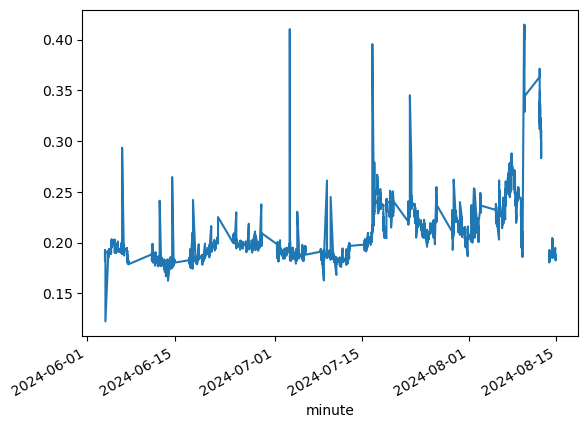

In [13]:
atm_iv.iv_atm.plot()

**ATM IV trading**:

* 第一，检测并确认是否需要过滤掉outliers。
* 第二，可以直接计算rolling quantile交易ATM IV。
* 第三，可以对ATM IV运用时间序列分析或者预测，比如 LSTM，去预测IV。

不过此次分析不在此方向展开，主要研究local skew。

#### 可视化skew统计性质

* 确定是否有均值回归现象。
* 确定哪些diff step 存在比较明显的均值回归。
* 确定均值回归的平均时间（半衰期）。

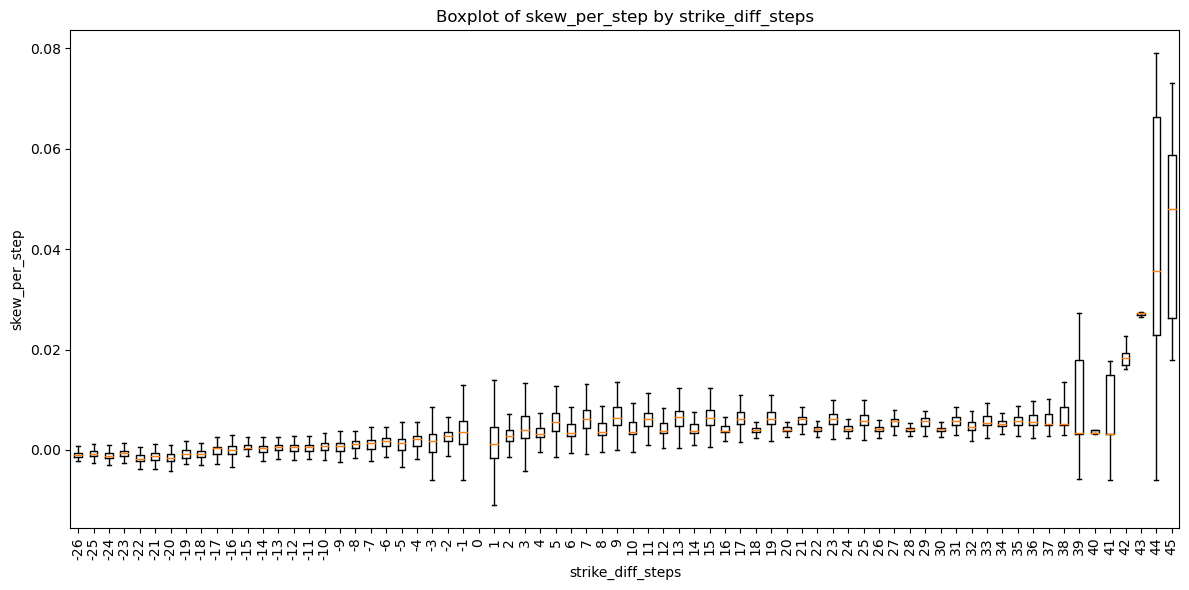

In [14]:
CF.plot_box(df_skew)

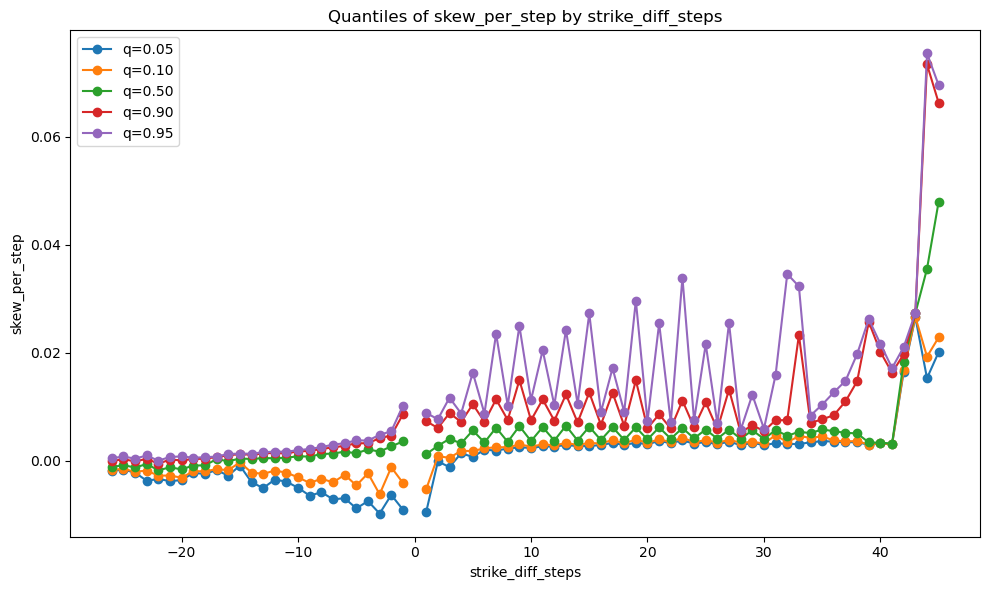

In [15]:
CF.plot_quantile(df_skew)

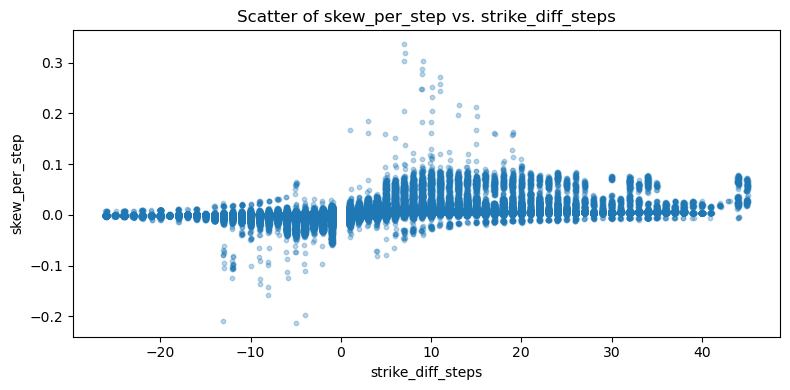

In [16]:
CF.plot_scatter(df_skew)

In [17]:
CF_sig=Signals([0.1,0.9])

In [18]:
events_df=CF_sig.get_signals(df_skew)

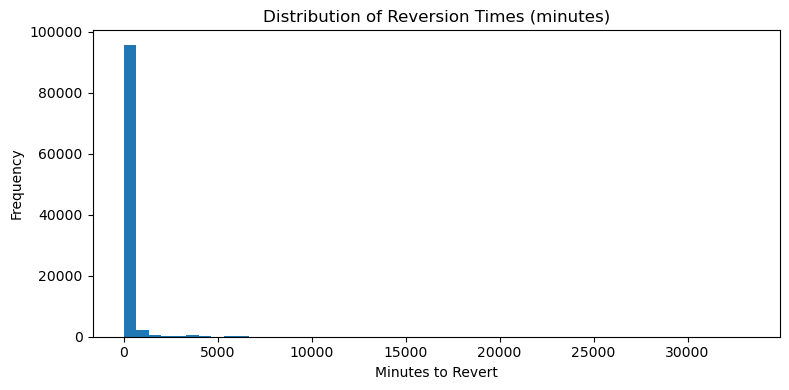

<Figure size 1000x400 with 0 Axes>

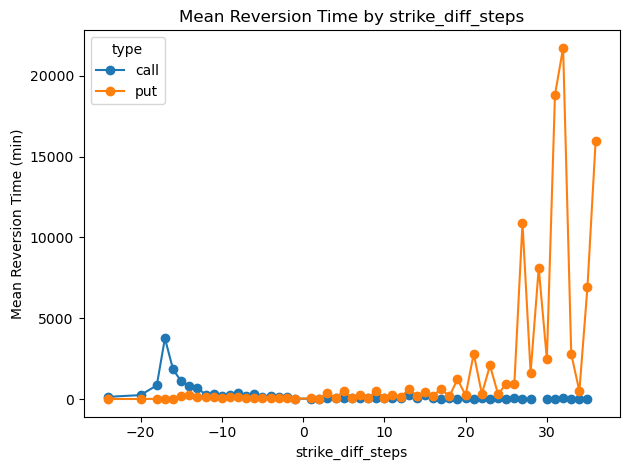

Overall mean reversion times (min):
type
call    122.182527
put     218.590843
Name: dt, dtype: float64


In [19]:
events_df,agg=CF_sig.plot(events_df)

In [20]:
agg

type,call,put
steps,,
-24,135.392157,2.657895
-20,244.210526,3.027027
-18,848.104478,12.654762
-17,3764.105263,30.380952
-16,1834.600000,4.981818
-15,1105.561538,193.833333
-14,793.973422,246.026786
-13,712.555000,108.296512
-12,257.318095,106.406349


#### 结论

* 选择step size 从-5，到10.
* 选择qunatile0.05和0.95作为入场信号，quantile 0.5 作为平仓信号。

### 回测

In [21]:
df = df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True)


In [22]:
CF.bact_test(df)

总笔数： 3276
总 PnL： -15247.725630736699
平均单笔 PnL： -4.654372903155281
胜率： 0.020451770451770452
      count      mean           sum       std
type                                         
call   1449 -1.576507  -2284.358506  1.253292
put    1827 -7.095439 -12963.367125  9.206872
       count      mean
steps                 
2       3276 -4.654373


对于菜柏期权而言，看起来step 2上可以优化，考虑双边ask-bid价差，离盈利挺近了。